# Quantum AE Notebook - Elias Michael

## Variational Quantum AutoEncoder 

### Import Libraries

In [1]:
import pennylane as qml
import jax
import jax.numpy as jnp
import numpy as np
import optax
from jax import jit, value_and_grad, vmap
import matplotlib.pyplot as plt

In [2]:
# JAX command for further accuracy
jax.config.update("jax_enable_x64", True)

### Defining the Qubit Setup

In [3]:
n_qubits = 5
latent_wire = 0 # First input of the encoder / Holds all the compressed info after training (encoder)
latent_wire_ii = 1 # Second input of the encoder / Holds all the compressed info after training (encoder)
trash_wire = 2 # Third input of the encoder / Discarded (Traced out) after training
reference_wire = 3 # Used to compare with trash qubit after encoder, then used as a fresh qubit for the decoder input
ancilla_wire = 4 # For measuring the similarity in SWAP test
dev = qml.device("default.qubit.jax", wires=n_qubits)

### Data Generation

In [4]:
# Centering the circle in the reversible domain (0, pi)
ds = (jnp.pi - 2)/2

In [5]:
def generate_sphere(n_samples=3000, seed=0):
    rng = np.random.default_rng(seed)
    phi = rng.uniform(0, 2 * np.pi, n_samples)
    costheta = rng.uniform(-1, 1, n_samples)
    theta = np.arccos(costheta)
    #phi = rng.uniform(0, 1/2 * np.pi, n_samples)
    #theta = rng.uniform(0, 0.5 * np.pi, n_samples)

    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    # Shift the coordinates to [0, 2] range
    shifted_coords = np.stack([x+1+ds, y+1+ds, z+1+ds], axis=1).astype(np.float32)
    return shifted_coords

### Encoder Layer (Angle embedding & Re-Uploading & Alternate Embedding)

In [6]:
def expressive_block_circuit5(x, weights, wires, 
                               reupload=True, 
                               alternate_embedding=True):
    n_layers = weights.shape[0]  # e.g., 2 or 3
    n_wires = len(wires)
    index = sorted(list(range(len(x))) * (n_wires // len(x) + 1))

    def embed_inputs(layer):
        for idx, wire in enumerate(wires):
            if not alternate_embedding:
                gate = qml.RY
            else:
                # Alternate embedding gates per layer
                if layer % 2 == 0:
                    gate = [qml.RY, qml.RX, qml.RY][idx % 3]
                else:
                    gate = [qml.RX, qml.RY, qml.RX][idx % 3]
            gate(x[index[idx]], wires=wire)

    for l in range(n_layers):
        if l == 0 or reupload:
            embed_inputs(l)

        # --- Initial RX + RZ rotations (as in Circuit 5) ---
        for i, wire in enumerate(wires):
            qml.RX(weights[l, i, 0], wires=wire)
            qml.RZ(weights[l, i, 1], wires=wire)

        # --- Staircase entanglement with interleaved RZ gates ---
        for i in range(n_wires - 1):
            # Optional mid-layer RZs (imitating interleaved ones in Circuit 5)
            qml.RZ(weights[l, i, 2], wires=wires[i])
            qml.CNOT(wires=[wires[i], wires[i + 1]])

        # Add final RZ gates on remaining qubits to match diagram
        qml.RZ(weights[l, n_wires - 1, 2], wires=wires[n_wires - 1])

        # --- Final RX + RZ again (as in last part of Circuit 5) ---
        for i, wire in enumerate(wires):
            qml.RX(weights[l, i, 3], wires=wire)
            qml.RZ(weights[l, i, 4], wires=wire)


In [6]:
def expressive_block(x, weights, wires, 
                     rot=[qml.RY, qml.RZ, qml.RX], 
                     reupload=True, 
                     alternate_embedding=True):
    n_layers = weights.shape[0]
    n_wires = len(wires)
    index = sorted(list(range(len(x))) * (n_wires // len(x) + 1))

    def embed_inputs(layer):
        for idx, wire in enumerate(wires):
            if not alternate_embedding:
                gate = qml.RY
            else:
                # Layer-dependent alternating embedding
                if layer % 2 == 0:
                    gate = [qml.RY, qml.RX, qml.RY][idx % 3]
                else:
                    gate = [qml.RX, qml.RY, qml.RX][idx % 3]
            gate(x[index[idx]], wires=wire)

    for l in range(n_layers):
        if l == 0 or reupload:
            embed_inputs(l)

        for i, wire in enumerate(wires):
            for j, gate in enumerate(rot):
                gate(weights[l, i, j], wires=wire)

        for i in range(n_wires):
            qml.CNOT(wires=[wires[i], wires[(i + 1) % n_wires]])


### Decoding Layer (Inverse Operators - Mirroring Encoder)

In [7]:
def adjoint_expressive_block_circuit5(x, weights, wires, 
                                      reupload=True, 
                                      alternate_embedding=True):
    n_layers = weights.shape[0]
    n_wires = len(wires)
    index = sorted(list(range(len(x))) * (n_wires // len(x) + 1))

    def embed_inputs(layer):
        for idx, wire in enumerate(wires):
            if not alternate_embedding:
                gate = qml.RY
            else:
                # Same alternating logic as forward pass
                if layer % 2 == 0:
                    gate = [qml.RY, qml.RX, qml.RY][idx % 3]
                else:
                    gate = [qml.RX, qml.RY, qml.RX][idx % 3]
            # Inverse embedding (negate angle)
            gate(-x[index[idx]], wires=wire)

    # Iterate over layers in reverse
    for l in reversed(range(n_layers)):

        # Final RX + RZ (undo first)
        for i, wire in enumerate(wires):
            qml.RZ(-weights[l, i, 4], wires=wire)
            qml.RX(-weights[l, i, 3], wires=wire)

        # Undo interleaved RZ and CNOTs (reversed order)
        qml.RZ(-weights[l, n_wires - 1, 2], wires=wires[n_wires - 1])

        for i in reversed(range(n_wires - 1)):
            qml.CNOT(wires=[wires[i], wires[i + 1]])  # CNOT is self-inverse
            qml.RZ(-weights[l, i, 2], wires=wires[i])

        # Undo initial RX + RZ
        for i, wire in enumerate(wires):
            qml.RZ(-weights[l, i, 1], wires=wire)
            qml.RX(-weights[l, i, 0], wires=wire)

        # Optionally undo input embedding
        if l == 0 or reupload:
            embed_inputs(l)


In [7]:
def expressive_block_adjoint(x, weights, wires, 
                             rot=[qml.RY, qml.RZ, qml.RX], 
                             reupload=True, 
                             alternate_embedding=True):
    """
    Adjoint of expressive block with fixed ZXZ (or YZY, etc.) composition and
    alternating RY/RX data reuploading (layer-dependent).
    """
    n_layers = weights.shape[0]
    n_wires = len(wires)
    index = sorted(list(range(len(x))) * (n_wires // len(x) + 1))

    def embed_inputs_adjoint(layer):
        for idx, wire in reversed(list(enumerate(wires))):
            if not alternate_embedding:
                gate = qml.RY
            else:
                # Reverse layer-dependent reembedding sequence
                if layer % 2 == 0:
                    gate = [qml.RY, qml.RX, qml.RY][idx % 3]
                else:
                    gate = [qml.RX, qml.RY, qml.RX][idx % 3]
            qml.adjoint(gate)(x[index[idx]], wires=wire)

    for l in reversed(range(n_layers)):
        # Reverse entanglement
        for i in reversed(range(n_wires)):
            qml.adjoint(qml.CNOT)(wires=[wires[i], wires[(i + 1) % n_wires]])

        # Reverse parameterized gates
        for i in reversed(range(n_wires)):
            for j in reversed(range(len(rot))):
                qml.adjoint(rot[j])(weights[l, i, j], wires=wires[i])

        # Reverse reuploading
        if l == 0 or reupload:
            embed_inputs_adjoint(l)


### SWAP Test (Loss Function Measurement)

In the SWAP Test we train only for the encoder parameters, since for the decoder we will just apply the inverse of all the encoder layers

In [8]:
@qml.qnode(dev, interface="jax")
def swap_test_circuit(params, x):
    # Prepare reference state
    qml.RX(x[0], wires=latent_wire)
    qml.RX(x[1], wires=latent_wire_ii)
    qml.RX(x[2], wires=trash_wire)


    # Encode data
    expressive_block_circuit5(
        x=x,
        weights=params,
        wires=[latent_wire, latent_wire_ii, trash_wire],
        reupload=True,
        alternate_embedding=True
    )

    # SWAP test
    qml.Hadamard(wires=ancilla_wire)
    qml.CSWAP(wires=[ancilla_wire, trash_wire, reference_wire])
    qml.Hadamard(wires=ancilla_wire)

    return qml.expval(qml.PauliZ(ancilla_wire))

In [9]:
@qml.qnode(dev, interface="jax")
def swap_test_circuit(params, x):
    # Prepare reference state
    qml.RX(x[0], wires=latent_wire)
    qml.RX(x[1], wires=latent_wire_ii)
    qml.RX(x[2], wires=trash_wire)


    # Encode data
    expressive_block(
        x=x,
        weights=params,
        wires=[latent_wire, latent_wire_ii, trash_wire],
        rot=[qml.RY, qml.RZ, qml.RX],
        reupload=True,
        alternate_embedding=True
    )

    # SWAP test
    qml.Hadamard(wires=ancilla_wire)
    qml.CSWAP(wires=[ancilla_wire, trash_wire, reference_wire])
    qml.Hadamard(wires=ancilla_wire)

    return qml.expval(qml.PauliZ(ancilla_wire))

#### Batched Loss Function

In [9]:
def swap_test_loss(params, batch):
    def single_sample_loss(x):
        ancilla_z = swap_test_circuit(params, x)
        return 1.0 - ancilla_z  
    batched_loss = vmap(single_sample_loss)(batch)
    return jnp.mean(batched_loss)

In [10]:
# JAX Speed Optimizer
loss_fn = jit(swap_test_loss)

### Parameters Initialization

In [11]:
def init_encoder_params(n_layers=20, n_wires=3, n_rot=3, seed=0):
    key = jax.random.PRNGKey(seed)
    return jax.random.uniform(
        key, shape=(n_layers, n_wires, n_rot), minval=-1, maxval=1
    )

In [12]:
# Initialize weights
n_layers, n_wires, n_rot = 10, 3, 5
params = init_encoder_params(n_layers, n_wires, n_rot)

### Training Data

In [13]:
# Generating the dataset
data = generate_sphere(n_samples=3000, seed=42)

# --- Shuffle uniformly
rng = np.random.default_rng(42)
indices = np.arange(len(data))
rng.shuffle(indices)

# --- Select stratified validation set (even angle spacing)
val_size = int(0.2 * len(data))
val_indices = np.linspace(0, len(data) - 1, num=val_size, dtype=int)
val_indices = indices[val_indices]

# --- Remaining indices for training
train_indices = np.setdiff1d(indices, val_indices)

# --- Final splits
train_data = data[train_indices]
val_data = data[val_indices]

### Learning Rate & Optimizer Scheduler Setup

In [14]:
# Learning rate scheduler setup
initial_lr = 0.1
decay_rate = 0.8
decay_steps = 1000  # decay every 1000 steps

schedule = optax.exponential_decay(
    init_value=initial_lr,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

In [15]:
# Optimizer with schedule
optimizer = optax.adam(learning_rate=schedule)
opt_state = optimizer.init(params)

### Training Loop

In [16]:
# Training Parameters
batch_size = 64
epochs = 30000

In [17]:
# JAX Speed Optimizer
loss_grad_fn = jit(value_and_grad(swap_test_loss))

# Logging Arrays
loss_history = []
val_loss_history = []
grad_norm_history = []
lr_history = []

In [18]:
# Early stopping setup 
best_val_loss = float("inf")
patience = 50
epochs_without_improvement = 0

In [19]:
# Training loop
for epoch in range(epochs):
    # Sample random training batch
    batch_idx = np.random.choice(train_data.shape[0], batch_size, replace=False)
    batch = train_data[batch_idx]

    # Compute training loss and gradients
    loss_val, grads = loss_grad_fn(params, batch)

    # Compute gradient norm
    flat_grads, _ = jax.flatten_util.ravel_pytree(grads)
    grad_norm = jnp.linalg.norm(flat_grads)

    # Update step
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    # Track metrics
    loss_history.append(loss_val)
    grad_norm_history.append(grad_norm)
    lr_history.append(schedule(epoch))

    # --- Validation ---
    if epoch % 100 == 0 or epoch == epochs - 1:
        val_loss = swap_test_loss(params, val_data)
        val_loss_history.append(val_loss)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Logging
        print(f"Epoch {epoch:5d} | Train Loss: {loss_val:.8f} | Val Loss: {val_loss:.8f} | Grad Norm: {grad_norm:.4e} | LR: {lr_history[-1]:.6f}")

        # Stop if no improvement
        if epochs_without_improvement >= patience:
            print(f"\n⏹️ Early stopping at epoch {epoch} (val loss stagnated for {patience} steps)")
            break

Epoch     0 | Train Loss: 0.59148778 | Val Loss: 0.30088447 | Grad Norm: 5.7353e-01 | LR: 0.100000
Epoch   100 | Train Loss: 0.00929885 | Val Loss: 0.00852926 | Grad Norm: 1.0341e-01 | LR: 0.100000
Epoch   200 | Train Loss: 0.00415980 | Val Loss: 0.00692906 | Grad Norm: 4.6430e-02 | LR: 0.100000
Epoch   300 | Train Loss: 0.00487630 | Val Loss: 0.00566129 | Grad Norm: 1.0746e-01 | LR: 0.100000
Epoch   400 | Train Loss: 0.00285842 | Val Loss: 0.00302103 | Grad Norm: 7.0279e-02 | LR: 0.100000
Epoch   500 | Train Loss: 0.00533333 | Val Loss: 0.00552043 | Grad Norm: 1.8032e-01 | LR: 0.100000
Epoch   600 | Train Loss: 0.00217923 | Val Loss: 0.00381783 | Grad Norm: 5.3128e-02 | LR: 0.100000
Epoch   700 | Train Loss: 0.00367214 | Val Loss: 0.00340588 | Grad Norm: 1.1286e-01 | LR: 0.100000
Epoch   800 | Train Loss: 0.01255011 | Val Loss: 0.01108659 | Grad Norm: 2.8054e-01 | LR: 0.100000
Epoch   900 | Train Loss: 0.00167564 | Val Loss: 0.00313030 | Grad Norm: 6.1095e-02 | LR: 0.100000
Epoch  100

### Full AutoEncoder Circuit (With Reconstruction)

In [20]:
@qml.qnode(dev, interface="jax")
def recon_points(params, x):
    # Prepare reference state
    qml.RX(x[0], wires=latent_wire)
    qml.RX(x[1], wires=latent_wire_ii)
    qml.RX(x[2], wires=trash_wire)
           
    # Encode data
    expressive_block_circuit5(
        x=x,
        weights=params,
        wires=[latent_wire, latent_wire_ii, trash_wire],
        reupload=True,
        alternate_embedding=True
    )

    # Reset trash qubit using SWAP from reference
    qml.SWAP(wires=[trash_wire, reference_wire])   

    # Decode data
    adjoint_expressive_block_circuit5(
        x=x,
        weights=params,
        wires=[latent_wire, latent_wire_ii, trash_wire],
        reupload=True,
        alternate_embedding=True
    )

    z0 = qml.expval(qml.PauliZ(latent_wire))
    z1 = qml.expval(qml.PauliZ(latent_wire_ii))
    z2 = qml.expval(qml.PauliZ(trash_wire))
    return z0 ,z1, z2

## Testing the Model

### Test Data

In [21]:
test_data = generate_sphere(n_samples=100, seed=1)

### Output Qubits & Latent Qubit Measurement

In [22]:
# Output Z (Z=cosx)
z_expectations_out = jax.vmap(lambda x: recon_points(params, x))(test_data)
# Stack the outputs to shape (N, 3)
z_expectations_out_stacked = jnp.stack(z_expectations_out, axis=-1)  # from (3, N) → (N, 3)

In [23]:
# Reconstructed points [arccos(z)=x_recon]
recon = jnp.arccos(z_expectations_out_stacked) 

### Graphs

#### Reconstruction Plot

In [24]:
import plotly.graph_objects as go

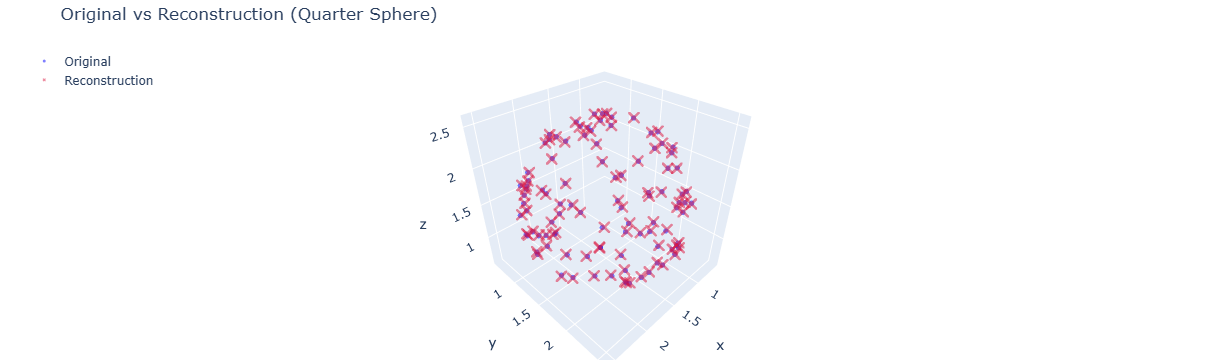

In [25]:
# Create traces
trace_original = go.Scatter3d(
    x=test_data[:, 0],
    y=test_data[:, 1],
    z=test_data[:, 2],
    mode='markers',
    name='Original',
    marker=dict(size=3, color='blue', opacity=0.5)
)

trace_recon = go.Scatter3d(
    x=recon[:, 0],
    y=recon[:, 1],
    z=recon[:, 2],
    mode='markers',
    name='Reconstruction',
    marker=dict(size=3, color='crimson', symbol='x', opacity=0.5)
)

# Combine and plot
fig = go.Figure(data=[trace_original, trace_recon])
fig.update_layout(
    title="Original vs Reconstruction (Quarter Sphere)",
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='z'
    ),
    legend=dict(x=0.02, y=0.98),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


### Testing with Gaussian Noise (mild anomaly) / Roustness test

In [ ]:
# Gaussian Noise (mild anomaly) / Roustness test
def generate_noisy_circle(n_samples=300, seed=42, noise_std=0.1):
    data, angles = generate_circle_dataset(n_samples, seed)
    key = jax.random.PRNGKey(seed)
    noise = noise_std * jax.random.normal(key, shape=data.shape)
    noisy_data = data + noise
    return noisy_data, angles

In [ ]:
# Data
noisy_data, true_angles = generate_noisy_circle(n_samples=500, seed=1)
# Latent Z
z_expectations_n = jax.vmap(lambda x: latent_qubit_z(params, x))(noisy_data)
# Output Z (Z=cosx)
z_expectations_out_n = jax.vmap(lambda x: recon_points(params, x))(noisy_data)
# Stack the outputs to shape (N, 2)
z_expectations_out_stacked_n = jnp.stack(z_expectations_out_n, axis=-1)  # from (2, N) → (N, 2)
# Reconstructed points [arccos(z)=x_recon]
recon_n = jnp.arccos(z_expectations_out_stacked_n) 

In [ ]:
# Sort by angle for nicer plotting
sorted_idx = jnp.argsort(true_angles)
sorted_angles_n = true_angles[sorted_idx]
sorted_zs_n = z_expectations_n[sorted_idx]

plt.figure(figsize=(8, 4))
plt.plot(sorted_angles_n, sorted_zs_n, label='⟨Z⟩ of latent qubit')
plt.xlabel("True angle (radians)")
plt.ylabel("⟨Z⟩ expectation")
plt.title("Latent qubit ⟨Z⟩ vs. True input angle")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(noisy_data[:, 0], noisy_data[:, 1], s=8, alpha=0.5, label='Original', edgecolor='k')
plt.scatter(recon_n[:, 0], recon_n[:, 1], s=8, alpha=0.5, label='Reconstruction', marker='x', color='crimson')
plt.legend(fontsize=12)
plt.title("Original vs Reconstruction (S¹)", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Testing with artificial gaps

In [ ]:
def generate_circle_with_gap(n_samples=300, seed=42, gap_range=(jnp.pi/3, jnp.pi/2)):
    key = jax.random.PRNGKey(seed)
    # Sample until enough valid points are outside the gap
    valid_angles = []
    while len(valid_angles) < n_samples:
        angles = jax.random.uniform(key, shape=(n_samples,), minval=0, maxval=2*jnp.pi)
        filtered = angles[(angles < gap_range[0]) | (angles > gap_range[1])]
        valid_angles.extend(filtered.tolist())
        key, _ = jax.random.split(key)

    angles = jnp.array(valid_angles[:n_samples])
    data = jnp.stack([jnp.cos(angles)+1, jnp.sin(angles)+1], axis=1)
    return data, angles


In [ ]:
# Data
gap_data, true_angles = generate_circle_with_gap(n_samples=500, seed=1)
# Latent Z
z_expectations_g = jax.vmap(lambda x: latent_qubit_z(params, x))(gap_data)
# Output Z (Z=cosx)
z_expectations_out_g = jax.vmap(lambda x: recon_points(params, x))(gap_data)
# Stack the outputs to shape (N, 2)
z_expectations_out_stacked_g = jnp.stack(z_expectations_out_g, axis=-1)  # from (2, N) → (N, 2)
# Reconstructed points [arccos(z)=x_recon]
recon_g = jnp.arccos(z_expectations_out_stacked_g) 

In [ ]:
# Sort by angle for nicer plotting
sorted_idx = jnp.argsort(true_angles)
sorted_angles_g = true_angles[sorted_idx]
sorted_zs_g = z_expectations_g[sorted_idx]

plt.figure(figsize=(8, 4))
plt.plot(sorted_angles_g, sorted_zs_g, label='⟨Z⟩ of latent qubit')
plt.axvline(x=jnp.pi / 3, color='red', linestyle='dotted', label=r'$x = \frac{\pi}{3}$')
plt.axvline(x=jnp.pi / 2, color='red', linestyle='dotted', label=r'$x = \frac{\pi}{2}$')
plt.xlabel("True angle (radians)")
plt.ylabel("⟨Z⟩ expectation")
plt.title("Latent qubit ⟨Z⟩ vs. True input angle")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(gap_data[:, 0], gap_data[:, 1], s=8, alpha=0.5, label='Original', edgecolor='k')
plt.scatter(recon_g[:, 0], recon_g[:, 1], s=8, alpha=0.5, label='Reconstruction', marker='x', color='crimson')
plt.legend(fontsize=12)
plt.title("Original vs Reconstruction (S¹)", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Testing for data corruption (injected outliers / spikes off the circle)

In [ ]:
def generate_circle_with_outliers(n_samples=300, seed=42, outlier_fraction=0.1):
    data, angles = generate_circle_dataset(n_samples, seed)
    n_outliers = int(n_samples * outlier_fraction)

    key = jax.random.PRNGKey(seed)
    outlier_points = jax.random.uniform(key, shape=(n_outliers, 2), minval=2, maxval=3)

    # Replace random entries with outliers
    indices = np.random.choice(n_samples, n_outliers, replace=False)
    data = data.at[indices].set(outlier_points)

    return data, angles

In [ ]:
# Data
spike_data, true_angles = generate_circle_with_outliers(n_samples=500, seed=1)
# Latent Z
z_expectations_s = jax.vmap(lambda x: latent_qubit_z(params, x))(spike_data)
# Output Z (Z=cosx)
z_expectations_out_s = jax.vmap(lambda x: recon_points(params, x))(spike_data)
# Stack the outputs to shape (N, 2)
z_expectations_out_stacked_s = jnp.stack(z_expectations_out_s, axis=-1)  # from (2, N) → (N, 2)
# Reconstructed points [arccos(z)=x_recon]
recon_s = jnp.arccos(z_expectations_out_stacked_s) 

In [ ]:
# Sort by angle for nicer plotting
sorted_idx = jnp.argsort(true_angles)
sorted_angles_s = true_angles[sorted_idx]
sorted_zs_s = z_expectations_s[sorted_idx]

plt.figure(figsize=(8, 4))
plt.plot(sorted_angles_s, sorted_zs_s, label='⟨Z⟩ of latent qubit')
plt.xlabel("True angle (radians)")
plt.ylabel("⟨Z⟩ expectation")
plt.title("Latent qubit ⟨Z⟩ vs. True input angle")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(spike_data[:, 0], spike_data[:, 1], s=8, alpha=0.5, label='Original', edgecolor='k')
plt.scatter(recon_s[:, 0], recon_s[:, 1], s=8, alpha=0.5, label='Reconstruction', marker='x', color='crimson')
plt.legend(fontsize=12)
plt.title("Original vs Reconstruction (S¹)", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Testing systematic deviations (anomalous radius)

In [ ]:
def generate_off_circle(n_samples=300, seed=42, radius_shift=0.1):
    key = jax.random.PRNGKey(seed)
    angles = jax.random.uniform(key, shape=(n_samples,), minval=0, maxval=2*jnp.pi)
    r = 1.0 + radius_shift
    data = jnp.stack([r * jnp.cos(angles) + 1, r * jnp.sin(angles) + 1], axis=1)
    return data, angles

In [ ]:
# Data
rad_data, true_angles = generate_off_circle(n_samples=500, seed=1)
# Latent Z
z_expectations_r = jax.vmap(lambda x: latent_qubit_z(params, x))(rad_data)
# Output Z (Z=cosx)
z_expectations_out_r = jax.vmap(lambda x: recon_points(params, x))(rad_data)
# Stack the outputs to shape (N, 2)
z_expectations_out_stacked_r = jnp.stack(z_expectations_out_r, axis=-1)  # from (2, N) → (N, 2)
# Reconstructed points [arccos(z)=x_recon]
recon_r = jnp.arccos(z_expectations_out_stacked_r) 

In [ ]:
# Sort by angle for nicer plotting
sorted_idx = jnp.argsort(true_angles)
sorted_angles_r = true_angles[sorted_idx]
sorted_zs_r = z_expectations_r[sorted_idx]

plt.figure(figsize=(8, 4))
plt.plot(sorted_angles_r, sorted_zs_r, label='⟨Z⟩ of latent qubit')
plt.xlabel("True angle (radians)")
plt.ylabel("⟨Z⟩ expectation")
plt.title("Latent qubit ⟨Z⟩ vs. True input angle")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(rad_data[:, 0], rad_data[:, 1], s=8, alpha=0.5, label='Original', edgecolor='k')
plt.scatter(recon_r[:, 0], recon_r[:, 1], s=8, alpha=0.5, label='Reconstruction', marker='x', color='crimson')
plt.legend(fontsize=12)
plt.title("Original vs Reconstruction (S¹)", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()